# Prediksi Nilai NO2 Satu Hari Kedepan dengan KNN Regression (Lag 5)

**Tujuan**: Memprediksi nilai NO₂ satu hari ke depan menggunakan KNN Regression dengan 5 lagged features dan membandingkan dengan standar WHO

**Lokasi**: Bangkalan, Madura

**Data Source**: Sentinel-5P (Copernicus Data Space)

**Metode**: 
1. KNN Regression untuk prediksi nilai kontinyu (5 lag features)
2. Perbandingan dengan standar WHO (10 µg/m³ annual, 25 µg/m³ 24-hour)

**Periode**: Juni 2020 - Juni 2021

---

##  Standar WHO untuk NO₂

**World Health Organization (WHO)** menetapkan ambang batas konsentrasi Nitrogen Dioxide (NO₂) untuk kesehatan:

### Pedoman WHO untuk NO₂:
- **Rata-rata Tahunan (Annual Mean)**: Tidak melebihi **10 µg/m³**
- **Rata-rata 24 Jam**: Tidak melebihi **25 µg/m³**

### Konversi Unit:
Data Sentinel-5P menggunakan satuan **mol/m²** (kolom densitas vertikal), sedangkan WHO menggunakan **µg/m³** (konsentrasi permukaan).

### Konversi Sederhana (Aproksimasi):
Untuk konversi mol/m² ke µg/m³ (menggunakan ketinggian mixing layer ~1000m):

```
µg/m³ ≈ (mol/m² × Molar Mass × 10⁶) / Mixing Layer Height
µg/m³ ≈ (mol/m² × 46.01 g/mol × 10⁶ µg/g) / 1000 m
µg/m³ ≈ mol/m² × 46010
```

**Catatan**: Ini adalah konversi sederhana. Untuk hasil akurat, diperlukan data profil atmosfer dan mixing layer height yang sebenarnya.

### Interpretasi:
- **Model ini menggunakan regresi** untuk memprediksi nilai NO₂ dalam mol/m²
- Hasil prediksi akan **dibandingkan dengan standar WHO** (setelah konversi)
- Fokus pada **analisis nilai** dan **tren**, bukan klasifikasi binary

---

## Import Libraries

In [2]:
import openeo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    roc_auc_score, ConfusionMatrixDisplay
)

sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Semua library berhasil diimport")

Semua library berhasil diimport


---

# DATA UNDERSTANDING

**Data Understanding** adalah tahap untuk memahami karakteristik dan kualitas data sebelum melakukan analisis.

## Yang Dilakukan dalam Tahap Ini:

1. **Mengumpulkan Data** dari Sentinel-5P (satelit pemantau polusi udara)
2. **Mengeksplorasi Struktur Data**: Melihat jumlah baris, kolom, tipe data
3. **Statistik Deskriptif**: Mean, std, min, max dari NO₂
4. **Visualisasi Time Series**: Melihat pola dan trend data NO₂
5. **Deteksi Missing Values**: Mengidentifikasi data yang hilang
6. **Analisis Distribusi**: Memahami sebaran nilai NO₂

**Output**: Pemahaman tentang data NO₂ Bangkalan periode Juni 2020 - Juni 2021

---



## LANGKAH 1: Pengumpulan Data (Data Collection)

**Kategori: DATA UNDERSTANDING**

**Sumber**: Sentinel-5P via OpenEO (Copernicus Data Space)

**Output**: CSV dengan data NO₂ harian untuk periode Juni 2020 - Juni 2021

**Tujuan**:
- Mengumpulkan data time series NO₂ dari satelit
- Memahami struktur dan format data
- Menyimpan data mentah untuk analisis lanjutan

In [3]:
print("="*70)
print("LANGKAH 1: PENGUMPULAN DATA ")
print("="*70)

# Nama file CSV output
csv_filename = "timeseries.csv"

# CEK APAKAH FILE CSV SUDAH ADA
if os.path.exists(csv_filename):
    print(f"\n[INFO] File '{csv_filename}' sudah ada!")
    print("[INFO] Loading data dari file CSV yang tersimpan...")
    print("[INFO] Tidak perlu melakukan crawling ulang.\n")
    
    # Load data dari CSV yang sudah ada
    df = pd.read_csv(csv_filename)
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").reset_index(drop=True)
    
    print(f"[SUCCESS] Data berhasil di-load dari file lokal")
    print(f"  - Total records: {len(df)}")
    print(f"  - Periode: {df['date'].min()} hingga {df['date'].max()}")
    print(f"  - File: {csv_filename}")
    print(f"\nData pertama (5 baris):")
    print(df.head())
    
else:
    print(f"\n[INFO] File '{csv_filename}' tidak ditemukan.")
    print("[INFO] Memulai proses crawling data dari Sentinel-5P...")
    print("[INFO] Proses ini hanya dilakukan sekali.\n")
    
    try:
        # 1. Koneksi ke Copernicus Data Space
        print("[KONEKSI] Menghubungkan ke Copernicus Data Space...")
        connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()
        print("[KONEKSI] Berhasil terhubung dan terautentikasi!\n")

        # 2. Area of Interest (AOI) - Bangkalan, Madura
        aoi = {
            "type": "Polygon",
            "coordinates": [
                [
                    [112.65, -7.21],
                    [112.65, -7.34],
                    [112.80, -7.34],
                    [112.87, -7.21],
                    [112.65, -7.21],
                ]
            ],
        }

        # 3. Load data Sentinel-5P
        print("[PROSES] Loading collection Sentinel-5P...")
        s5p = connection.load_collection(
            "SENTINEL_5P_L2",
            spatial_extent={
                "west": 112.72456356837233,
                "south": -7.064639201806031,
                "east": 112.77959573996094,
                "north": -7.026115991674629,
            },
            temporal_extent=["2020-06-01", "2021-06-30"],
            bands=["NO2"],
        )

        # 4. Mask nilai negatif
        def mask_invalid(x):
            return x < 0

        s5p_masked = s5p.mask(s5p.apply(mask_invalid))

        # 5. Agregasi temporal (harian)
        print("[PROSES] Agregasi temporal (harian)...")
        daily_mean = s5p_masked.aggregate_temporal_period(period="day", reducer="mean")

        # 6. Agregasi spasial (mean dalam AOI)
        print("[PROSES] Agregasi spasial (mean dalam AOI)...")
        daily_mean_aoi = daily_mean.aggregate_spatial(geometries=aoi, reducer="mean")

        # 7. Jalankan batch job
        print("[PROSES] Mengirim batch job ke OpenEO...")
        job = daily_mean_aoi.execute_batch(out_format="CSV")
        print("\n[CRAWLING] Menunggu job OpenEO selesai...")

        while True:
            status = job.describe()["status"]
            print(f"[CRAWLING] Status: {status}")
            if status == "finished":
                break
            elif status == "error":
                raise RuntimeError("Job gagal")
            time.sleep(15)

        # 8. Unduh hasil
        print("\n[DOWNLOAD] Mengunduh hasil...")
        results = job.get_results()
        results.download_files("no2_results")

        # 9. Baca file CSV
        csv_files = [f for f in os.listdir("no2_results") if f.endswith(".csv")]
        df = pd.read_csv(os.path.join("no2_results", csv_files[0]))

        # 10. Data preprocessing dan SIMPAN ke CSV
        df["date"] = pd.to_datetime(df["date"])
        df = df.sort_values("date").reset_index(drop=True)
        df.to_csv(csv_filename, index=False)

        print(f"\n[SUCCESS] Data berhasil dikumpulkan dan disimpan")
        print(f"  - Total records: {len(df)}")
        print(f"  - Periode: {df['date'].min()} hingga {df['date'].max()}")
        print(f"  - File: {csv_filename}")
        print(f"\n[INFO] File '{csv_filename}' telah disimpan.")
        print(f"[INFO] Eksekusi berikutnya akan menggunakan file ini tanpa crawling ulang.")
        print(f"\nData pertama (5 baris):")
        print(df.head())
        
    except Exception as e:
        print(f"\n[ERROR] Terjadi kesalahan saat crawling data!")
        print(f"[ERROR] Jenis error: {type(e).__name__}")
        print(f"[ERROR] Pesan: {str(e)}\n")
        
        print("[SOLUSI] Beberapa opsi untuk mengatasi masalah ini:")
        print("1. Coba jalankan ulang sel ini (token mungkin expired)")
        print("2. Restart kernel dan jalankan dari awal")
        print("3. Gunakan data yang sudah tersimpan (jika pernah berhasil crawling)")
        print("4. Periksa koneksi internet Anda")
        print("5. Periksa status layanan OpenEO: https://openeo.dataspace.copernicus.eu/")
        
        # Cek apakah ada backup data
        if os.path.exists("no2_results"):
            backup_files = [f for f in os.listdir("no2_results") if f.endswith(".csv")]
            if backup_files:
                print(f"\n[INFO] Ditemukan backup data di folder 'no2_results'")
                print(f"[INFO] Mencoba load dari backup...")
                try:
                    df = pd.read_csv(os.path.join("no2_results", backup_files[0]))
                    df["date"] = pd.to_datetime(df["date"])
                    df = df.sort_values("date").reset_index(drop=True)
                    df.to_csv(csv_filename, index=False)
                    print(f"[SUCCESS] Data berhasil di-load dari backup!")
                    print(f"  - Total records: {len(df)}")
                    print(f"  - File: {csv_filename}")
                except Exception as backup_error:
                    print(f"[ERROR] Gagal load backup: {str(backup_error)}")
                    raise
            else:
                raise
        else:
            raise

LANGKAH 1: PENGUMPULAN DATA 

[INFO] File 'timeseries.csv' sudah ada!
[INFO] Loading data dari file CSV yang tersimpan...
[INFO] Tidak perlu melakukan crawling ulang.

[SUCCESS] Data berhasil di-load dari file lokal
  - Total records: 395
  - Periode: 2020-05-31 00:00:00+00:00 hingga 2021-06-29 00:00:00+00:00
  - File: timeseries.csv

Data pertama (5 baris):
                       date  feature_index       NO2
0 2020-05-31 00:00:00+00:00              0       NaN
1 2020-06-01 00:00:00+00:00              0       NaN
2 2020-06-02 00:00:00+00:00              0       NaN
3 2020-06-03 00:00:00+00:00              0  0.000017
4 2020-06-04 00:00:00+00:00              0  0.000021


---

# DATA PREPARATION

**Data Preparation** adalah tahap mempersiapkan data mentah menjadi format yang siap untuk modeling.

## Yang Dilakukan dalam Tahap Ini:

### 1. Handling Missing Values (Langkah 2)
- Mengisi missing values dengan **interpolasi linear**
- Backup dengan backfill dan forwardfill
- Memastikan tidak ada data yang hilang

### 2. Transformasi Time Series ke Supervised Learning (Langkah 3)
- Membuat **lagged features**: NO2(t-3), NO2(t-2), NO2(t-1)
- Menetapkan **target**: NO2(t)
- Mengubah format data menjadi input-output untuk machine learning

### 3. Train-Test Split & Threshold Definition (Langkah 4)
- Split data: 80% training, 20% testing (**shuffle=False** untuk time series)
- Menentukan **threshold** (75th percentile) **HANYA dari training set**
- **PENTING**: Split SEBELUM normalisasi untuk menghindari data leakage!

### 4. Normalisasi Data dengan MinMaxScaler (Langkah 5)
- Menggunakan **MinMaxScaler** untuk menskalakan data ke rentang [0, 1]
- **Fit scaler HANYA pada training set**, lalu transform training & test set
- **Menyimpan scaler ke file** (`minmax_scaler.pkl`) untuk deployment
- Menyamakan skala semua fitur
- Penting untuk KNN karena sensitif terhadap skala
- **Mencegah data leakage!**

**Output**: Data yang bersih, terstruktur, dan siap untuk training model tanpa data leakage + scaler tersimpan untuk deployment

---



## LANGKAH 2: Preprocessing - Interpolasi Missing Values

**Kategori: DATA PREPARATION**

**Tujuan**: Menangani missing values dengan interpolasi linier

**Proses**:
1. Identifikasi missing values (Data Understanding)
2. Interpolasi linear untuk mengisi missing values
3. Backup dengan backfill dan forwardfill
4. Validasi: memastikan tidak ada missing values tersisa


LANGKAH 2: PREPROCESSING - INTERPOLASI MISSING VALUES

Missing values SEBELUM: 139 (35.19%)
Missing values SESUDAH: 0

Statistik NO2 setelah interpolasi:
count    395.000000
mean       0.000041
std        0.000019
min        0.000006
25%        0.000027
50%        0.000036
75%        0.000051
max        0.000129
Name: NO2, dtype: float64


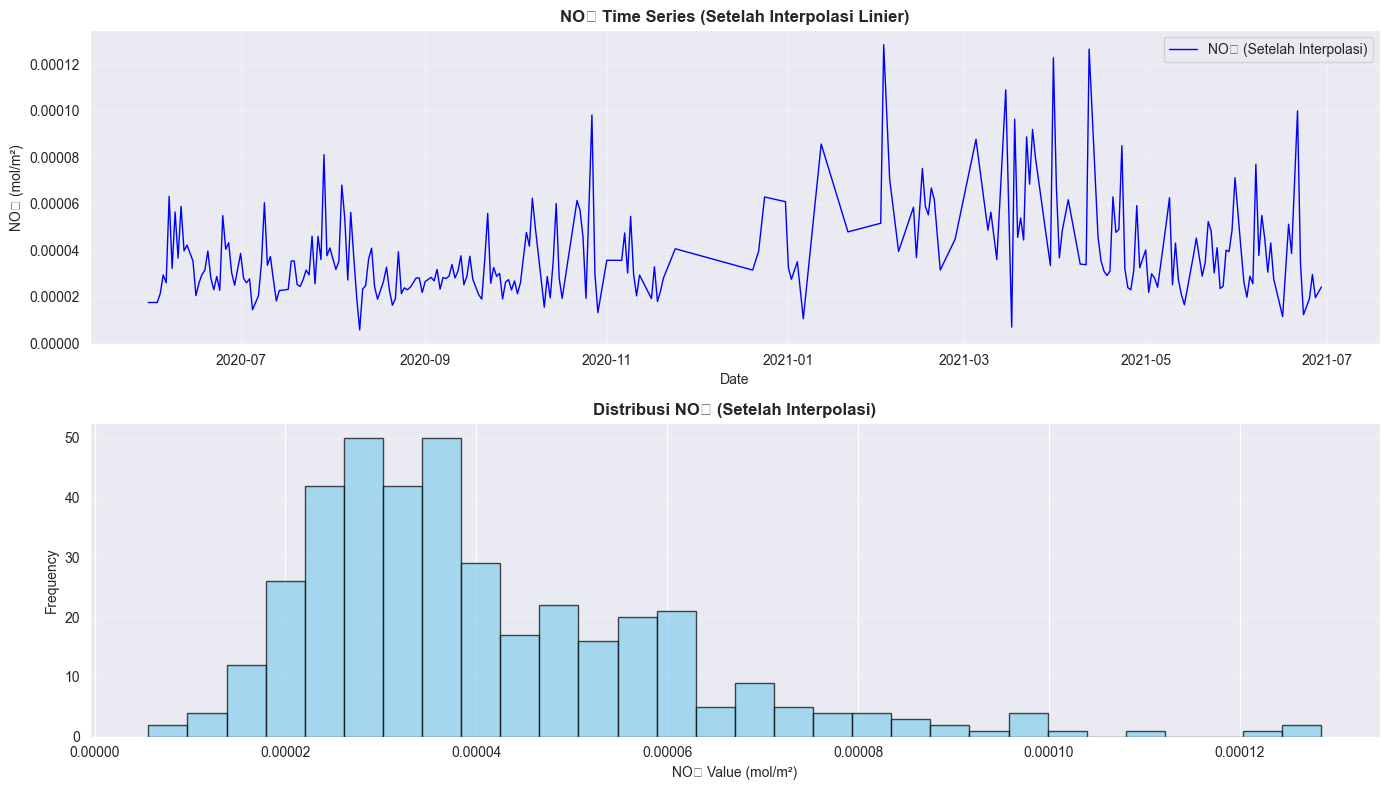


Preprocessing selesai


In [4]:
print("\n" + "="*70)
print("LANGKAH 2: PREPROCESSING - INTERPOLASI MISSING VALUES")
print("="*70)

# Baca data
df = pd.read_csv("timeseries.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

# Cek missing values SEBELUM
missing_before = df["NO2"].isna().sum()
print(f"\nMissing values SEBELUM: {missing_before} ({missing_before/len(df)*100:.2f}%)")

# Interpolasi linier
df["NO2"] = df["NO2"].interpolate(method="linear")
df["NO2"] = df["NO2"].fillna(method="bfill").fillna(method="ffill")

# Cek missing values SESUDAH
missing_after = df["NO2"].isna().sum()
print(f"Missing values SESUDAH: {missing_after}")

# Statistik
print(f"\nStatistik NO2 setelah interpolasi:")
print(df["NO2"].describe())

# Visualisasi
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(df["date"], df["NO2"], color="blue", linewidth=1, label="NO₂ (Setelah Interpolasi)")
axes[0].set_title("NO₂ Time Series (Setelah Interpolasi Linier)", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("NO₂ (mol/m²)")
axes[0].grid(True, alpha=0.3)
axes[0].legend()

axes[1].hist(df["NO2"], bins=30, edgecolor="black", alpha=0.7, color="skyblue")
axes[1].set_title("Distribusi NO₂ (Setelah Interpolasi)", fontsize=12, fontweight="bold")
axes[1].set_xlabel("NO₂ Value (mol/m²)")
axes[1].set_ylabel("Frequency")
axes[1].grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

print(f"\nPreprocessing selesai")

---

## LANGKAH 3: Transformasi ke Supervised Learning

**Kategori: DATA PREPARATION**

**Tujuan**: Konversi time series menjadi supervised dataset dengan lagged features

**Konsep**: Gunakan 5 hari terakhir (t-5, t-4, t-3, t-2, t-1) untuk memprediksi NO₂ hari ini (t)

**Proses**:
1. Membuat fungsi `series_to_supervised()`
2. Generate lagged features (NO2(t-5), NO2(t-4), NO2(t-3), NO2(t-2), NO2(t-1))
3. Set target variable (NO2(t))
4. Drop rows dengan NaN (hasil shifting)

In [5]:
print("\n" + "="*70)
print("LANGKAH 3: TRANSFORMASI KE SUPERVISED LEARNING")
print("="*70)

def series_to_supervised(data, n_in=1, n_out=1, dropna=True):
    """
    Konversi time series menjadi supervised learning dataset.
    """
    df_data = pd.DataFrame(data)
    cols, names = [], []

    # Input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df_data.shift(i))
        names += [f"NO2(t-{i})"]

    # Output sequence (t)
    for i in range(0, n_out):
        cols.append(df_data.shift(-i))
        if i == 0:
            names += ["NO2(t)"]
        else:
            names += [f"NO2(t+{i})"]

    agg = pd.concat(cols, axis=1)
    agg.columns = names

    if dropna:
        agg.dropna(inplace=True)

    return agg

# Gunakan 5 lag
n_lags = 5
supervised_df = series_to_supervised(df[["NO2"]], n_in=n_lags, n_out=1)

print(f"\nTransformasi supervised learning dengan lag={n_lags}")
print(f"  - Total samples: {len(supervised_df)}")
print(f"  - Input fitur: {n_lags} (t-1 hingga t-{n_lags})")
print(f"  - Target: 1 (t)")
print(f"\nData pertama (5 baris):")
print(supervised_df.head())


LANGKAH 3: TRANSFORMASI KE SUPERVISED LEARNING

Transformasi supervised learning dengan lag=5
  - Total samples: 390
  - Input fitur: 5 (t-1 hingga t-5)
  - Target: 1 (t)

Data pertama (5 baris):
   NO2(t-5)  NO2(t-4)  NO2(t-3)  NO2(t-2)  NO2(t-1)    NO2(t)
5  0.000017  0.000017  0.000017  0.000017  0.000021  0.000029
6  0.000017  0.000017  0.000017  0.000021  0.000029  0.000026
7  0.000017  0.000017  0.000021  0.000029  0.000026  0.000063
8  0.000017  0.000021  0.000029  0.000026  0.000063  0.000032
9  0.000021  0.000029  0.000026  0.000063  0.000032  0.000056


---

## LANGKAH 4: Train-Test Split

**Kategori: DATA PREPARATION**

**Tujuan**: Split data untuk training dan testing

**Proses**:
1. Split data: 80% training, 20% testing (**shuffle=False** untuk time series)
2. Mempersiapkan data untuk normalisasi

**PENTING**: Split dilakukan SEBELUM normalisasi untuk menghindari data leakage!


LANGKAH 4: TRAIN-TEST SPLIT

Data Preparation:
  - Features shape: (390, 5)
  - Target shape: (390,)
  - Target range: [0.00000564, 0.00012854] mol/m²

Train-Test Split (shuffle=False untuk time series):
  - Training set: 312 samples (80.0%)
  - Test set: 78 samples (20.0%)


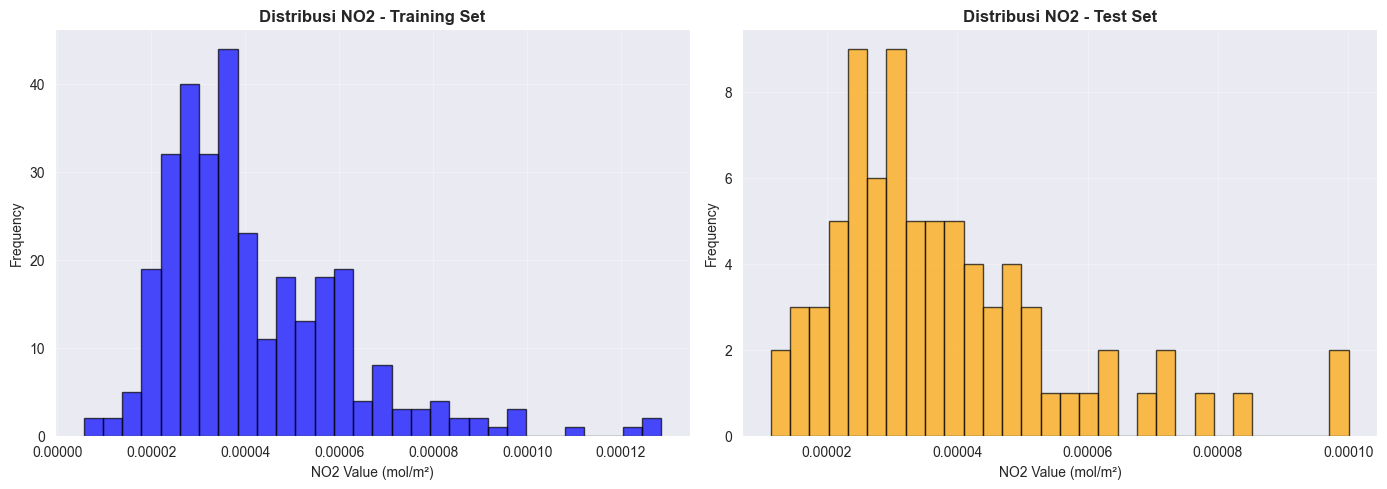


Data split selesai. Siap untuk normalisasi.


In [6]:
print("\n" + "="*70)
print("LANGKAH 4: TRAIN-TEST SPLIT")
print("="*70)

# Prepare data (SEBELUM normalisasi)
X = supervised_df.iloc[:, :-1].values  # Semua kolom kecuali NO2(t)
y = supervised_df.iloc[:, -1].values   # Hanya kolom NO2(t)

print(f"\nData Preparation:")
print(f"  - Features shape: {X.shape}")
print(f"  - Target shape: {y.shape}")
print(f"  - Target range: [{y.min():.8f}, {y.max():.8f}] mol/m²")

# Train-test split (SEBELUM normalisasi untuk menghindari data leakage)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

print(f"\nTrain-Test Split (shuffle=False untuk time series):")
print(f"  - Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  - Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

# Visualisasi distribusi train vs test
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(y_train, bins=30, edgecolor="black", alpha=0.7, color="blue")
axes[0].set_title("Distribusi NO2 - Training Set", fontsize=12, fontweight="bold")
axes[0].set_xlabel("NO2 Value (mol/m²)")
axes[0].set_ylabel("Frequency")
axes[0].grid(True, alpha=0.3)

axes[1].hist(y_test, bins=30, edgecolor="black", alpha=0.7, color="orange")
axes[1].set_title("Distribusi NO2 - Test Set", fontsize=12, fontweight="bold")
axes[1].set_xlabel("NO2 Value (mol/m²)")
axes[1].set_ylabel("Frequency")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nData split selesai. Siap untuk normalisasi.")

---

## LANGKAH 5: Normalisasi Data (SETELAH Split) dengan MinMaxScaler

**Kategori: DATA PREPARATION**

**Tujuan**: Normalisasi fitur dengan MinMaxScaler setelah split untuk menghindari data leakage

**Alasan**: 
- KNN sangat sensitif terhadap skala fitur
- MinMaxScaler menskalakan data ke rentang [0, 1]
- **Fit scaler HANYA pada training set**, lalu transform training dan test set
- **Simpan scaler untuk implementasi model pada data baru**
- Mencegah informasi dari test set bocor ke training set

**Proses**:
1. Fit MinMaxScaler **HANYA** pada X_train
2. Transform X_train dan X_test menggunakan scaler yang sama
3. **Simpan scaler ke file untuk digunakan saat deployment**
4. Target (y) TIDAK dinormalisasi


LANGKAH 5: NORMALISASI DATA (SETELAH SPLIT) - MinMaxScaler

Metode Normalisasi: MinMaxScaler
  - Formula: (x - min) / (max - min)
  - Range: [0, 1]
  - Setiap fitur diskalakan secara independen

Statistik Training Set SEBELUM normalisasi:
  - Min: [5.63569029e-06 5.63569029e-06 5.63569029e-06 5.63569029e-06
 5.63569029e-06]
  - Max: [0.00012854 0.00012854 0.00012854 0.00012854 0.00012854]
  - Mean: [4.10854815e-05 4.11607349e-05 4.12137876e-05 4.12664148e-05
 4.13186164e-05]

Statistik Training Set SESUDAH normalisasi:
  - Min: [0. 0. 0. 0. 0.]
  - Max: [1. 1. 1. 1. 1.]
  - Mean: [0.2884259  0.28903818 0.28946982 0.28989801 0.29032273]

Statistik Test Set SESUDAH normalisasi:
  - Min: [0.04699196 0.04699196 0.04699196 0.04699196 0.04699196]
  - Max: [0.98448205 0.98448205 0.98448205 0.98448205 0.98448205]
  - Mean: [0.28131186 0.27903473 0.27856689 0.277072   0.27582871]

✓ Scaler berhasil disimpan ke: minmax_scaler.pkl
  → Scaler ini akan digunakan untuk normalisasi data baru saat de

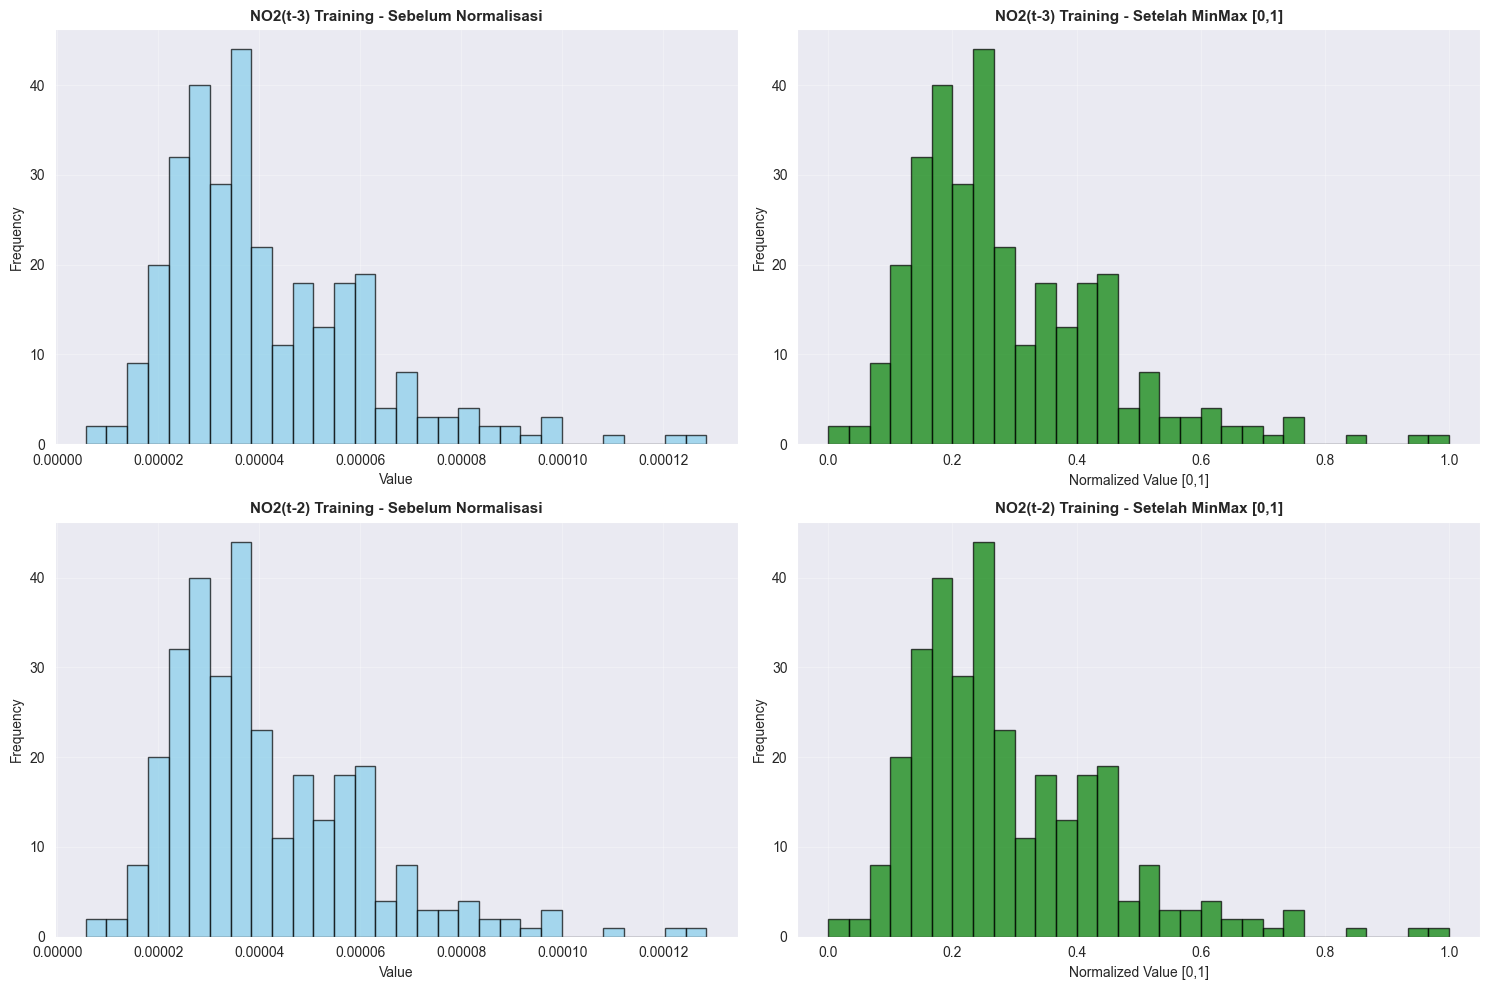


✓ Normalisasi selesai!
✓ Tidak ada data leakage - scaler hanya fit pada training set
✓ Scaler tersimpan untuk implementasi model pada data baru


In [7]:
print("\n" + "="*70)
print("LANGKAH 5: NORMALISASI DATA (SETELAH SPLIT) - MinMaxScaler")
print("="*70)

import joblib

# MinMaxScaler (normalisasi ke rentang [0, 1])
scaler = MinMaxScaler()

print(f"\nMetode Normalisasi: MinMaxScaler")
print(f"  - Formula: (x - min) / (max - min)")
print(f"  - Range: [0, 1]")
print(f"  - Setiap fitur diskalakan secara independen")


# Statistik SEBELUM normalisasi (training set)
print(f"\nStatistik Training Set SEBELUM normalisasi:")
print(f"  - Min: {X_train.min(axis=0)}")
print(f"  - Max: {X_train.max(axis=0)}")
print(f"  - Mean: {X_train.mean(axis=0)}")

# FIT scaler HANYA pada training set
scaler.fit(X_train)

# TRANSFORM training dan test set
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Statistik SESUDAH normalisasi
print(f"\nStatistik Training Set SESUDAH normalisasi:")
print(f"  - Min: {X_train_scaled.min(axis=0)}")
print(f"  - Max: {X_train_scaled.max(axis=0)}")
print(f"  - Mean: {X_train_scaled.mean(axis=0)}")

print(f"\nStatistik Test Set SESUDAH normalisasi:")
print(f"  - Min: {X_test_scaled.min(axis=0)}")
print(f"  - Max: {X_test_scaled.max(axis=0)}")
print(f"  - Mean: {X_test_scaled.mean(axis=0)}")

# SIMPAN SCALER untuk digunakan saat implementasi/deployment
scaler_filename = 'minmax_scaler.pkl'
joblib.dump(scaler, scaler_filename)
print(f"\n✓ Scaler berhasil disimpan ke: {scaler_filename}")
print(f"  → Scaler ini akan digunakan untuk normalisasi data baru saat deployment")

# Visualisasi perbandingan distribusi
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Fitur pertama (t-3) - Sebelum normalisasi
axes[0, 0].hist(X_train[:, 0], bins=30, edgecolor="black", alpha=0.7, color="skyblue")
axes[0, 0].set_title("NO2(t-3) Training - Sebelum Normalisasi", fontsize=11, fontweight="bold")
axes[0, 0].set_xlabel("Value")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].grid(True, alpha=0.3)

# Fitur pertama (t-3) - Setelah normalisasi (MinMax)
axes[0, 1].hist(X_train_scaled[:, 0], bins=30, edgecolor="black", alpha=0.7, color="green")
axes[0, 1].set_title("NO2(t-3) Training - Setelah MinMax [0,1]", fontsize=11, fontweight="bold")
axes[0, 1].set_xlabel("Normalized Value [0,1]")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].grid(True, alpha=0.3)

# Fitur kedua (t-2) - Sebelum normalisasi
axes[1, 0].hist(X_train[:, 1], bins=30, edgecolor="black", alpha=0.7, color="skyblue")
axes[1, 0].set_title("NO2(t-2) Training - Sebelum Normalisasi", fontsize=11, fontweight="bold")
axes[1, 0].set_xlabel("Value")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].grid(True, alpha=0.3)

# Fitur kedua (t-2) - Setelah normalisasi (MinMax)
axes[1, 1].hist(X_train_scaled[:, 1], bins=30, edgecolor="black", alpha=0.7, color="green")
axes[1, 1].set_title("NO2(t-2) Training - Setelah MinMax [0,1]", fontsize=11, fontweight="bold")
axes[1, 1].set_xlabel("Normalized Value [0,1]")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Normalisasi selesai!")
print(f"✓ Tidak ada data leakage - scaler hanya fit pada training set")
print(f"✓ Scaler tersimpan untuk implementasi model pada data baru")

---

# MODELLING

**Modelling** adalah tahap membangun, melatih, dan mengevaluasi model machine learning.

## Yang Dilakukan dalam Tahap Ini:

### 1. Model Training (Langkah 6)
- Memilih algoritma: **KNN Regression**
- **Eksperimen dengan nilai K** yang berbeda (2, 3, 5, 7, 9, 11)
- Training model untuk setiap K
- Evaluasi dengan metrik: **RMSE, MAE, R²**
- Memilih K terbaik (RMSE terkecil)

### 2. Model Evaluation (Langkah 7)
- Training model final dengan K terbaik
- **Prediksi nilai NO₂** pada test set
- Evaluasi performa regression (RMSE, MAE, R²)
- **Terapkan threshold** untuk klasifikasi
- Evaluasi performa classification (Accuracy, Precision, Recall, F1)
- Visualisasi dengan Confusion Matrix

### 3. Prediction Analysis (Langkah 8)
- Analisis error distribution
- Residual analysis
- Visualisasi performa model

### 4. Deployment (Langkah 9)
- **Prediksi NO₂ satu hari ke depan**
- Terapkan threshold untuk status (AMAN/BERBAHAYA)
- Interpretasi hasil prediksi

**Output**: Model KNN Regression terlatih dan hasil prediksi NO₂

---


## LANGKAH 6: KNN Regression Modeling

**Kategori: MODELLING**

**Tujuan**: Training model KNN Regression untuk memprediksi nilai NO₂ kontinyu dengan berbagai nilai K

**Proses**:
1. Gunakan data yang sudah di-split dan dinormalisasi (dari Langkah 4 & 5)
2. **Eksperimen dengan berbagai nilai K** (2, 3, 5, 7, 9, 11)
3. Training model untuk setiap K
4. Evaluasi dengan metrik regression (RMSE, MAE, R², MAPE)
5. Pilih K terbaik berdasarkan RMSE terkecil


LANGKAH 6: KNN REGRESSION MODELING

Menggunakan data yang sudah di-split dan dinormalisasi:
  - X_train_scaled shape: (312, 5)
  - X_test_scaled shape: (78, 5)
  - y_train shape: (312,)
  - y_test shape: (78,)

----------------------------------------------------------------------
EKSPERIMEN: Variasi Nilai K untuk KNN Regression
----------------------------------------------------------------------
k= 2 | RMSE=0.00002046 | MAE=0.00001502 | R²=-0.2474
k= 3 | RMSE=0.00001897 | MAE=0.00001430 | R²=-0.0723
k= 5 | RMSE=0.00001763 | MAE=0.00001347 | R²=0.0738
k= 7 | RMSE=0.00001760 | MAE=0.00001339 | R²=0.0769
k= 9 | RMSE=0.00001782 | MAE=0.00001372 | R²=0.0540
k=11 | RMSE=0.00001810 | MAE=0.00001400 | R²=0.0237

Best K: 7 (RMSE=0.00001760)


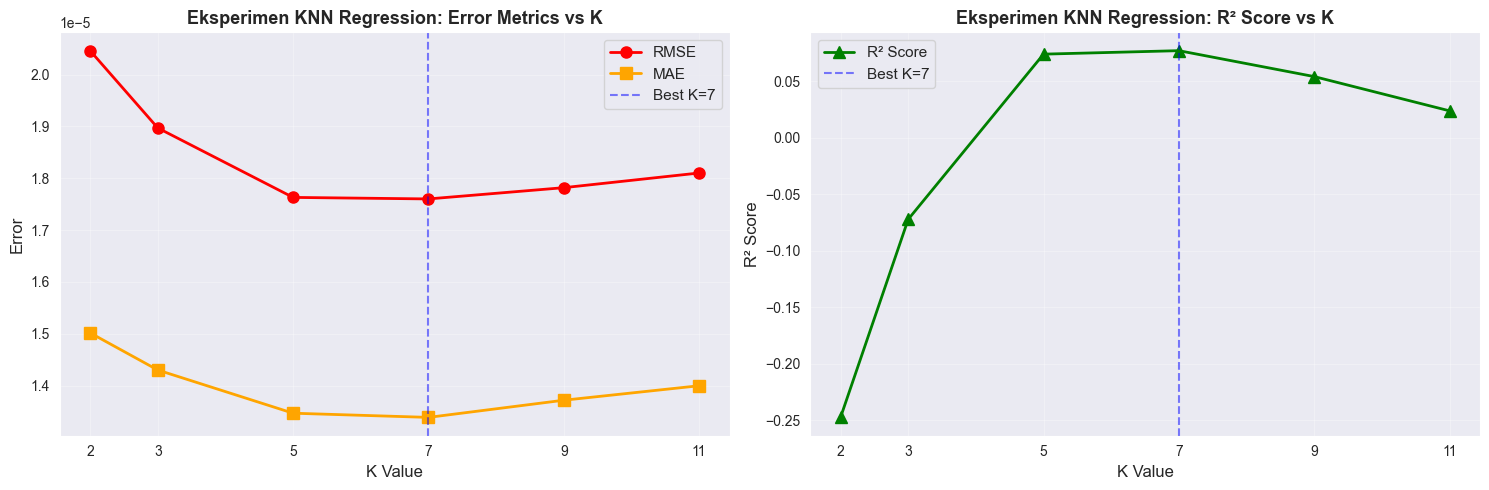

In [8]:
print("\n" + "="*70)
print("LANGKAH 6: KNN REGRESSION MODELING")
print("="*70)

# Gunakan data yang sudah di-split dan dinormalisasi dari Langkah 4 & 5
print(f"\nMenggunakan data yang sudah di-split dan dinormalisasi:")
print(f"  - X_train_scaled shape: {X_train_scaled.shape}")
print(f"  - X_test_scaled shape: {X_test_scaled.shape}")
print(f"  - y_train shape: {y_train.shape}")
print(f"  - y_test shape: {y_test.shape}")

# Eksperimen berbagai K
k_values = [2, 3, 5, 7, 9, 11]
print(f"\n" + "-"*70)
print(f"EKSPERIMEN: Variasi Nilai K untuk KNN Regression")
print("-"*70)

results_k = []
for k in k_values:
    model = KNeighborsRegressor(n_neighbors=k, metric='euclidean')
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    # Metrik regression
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results_k.append({
        'k': k,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    })
    
    print(f"k={k:2d} | RMSE={rmse:.8f} | MAE={mae:.8f} | R²={r2:.4f}")

results_k_df = pd.DataFrame(results_k)
best_k_idx = results_k_df['rmse'].idxmin()  # Cari K dengan RMSE terkecil
best_k = results_k_df.loc[best_k_idx, 'k']
best_rmse = results_k_df.loc[best_k_idx, 'rmse']

print(f"\nBest K: {int(best_k)} (RMSE={best_rmse:.8f})")

# Visualisasi performa vs K
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: RMSE dan MAE
axes[0].plot(results_k_df['k'], results_k_df['rmse'], marker='o', linewidth=2, markersize=8, label='RMSE', color='red')
axes[0].plot(results_k_df['k'], results_k_df['mae'], marker='s', linewidth=2, markersize=8, label='MAE', color='orange')
axes[0].axvline(x=best_k, color='blue', linestyle='--', alpha=0.5, label=f'Best K={int(best_k)}')
axes[0].set_xlabel('K Value', fontsize=12)
axes[0].set_ylabel('Error', fontsize=12)
axes[0].set_title('Eksperimen KNN Regression: Error Metrics vs K', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_values)

# Plot 2: R² Score
axes[1].plot(results_k_df['k'], results_k_df['r2'], marker='^', linewidth=2, markersize=8, label='R² Score', color='green')
axes[1].axvline(x=best_k, color='blue', linestyle='--', alpha=0.5, label=f'Best K={int(best_k)}')
axes[1].set_xlabel('K Value', fontsize=12)
axes[1].set_ylabel('R² Score', fontsize=12)
axes[1].set_title('Eksperimen KNN Regression: R² Score vs K', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_values)

plt.tight_layout()
plt.show()

---

## LANGKAH 7: Evaluasi Regression dengan Standar WHO

**Kategori: MODELLING (Evaluation)**

**Tujuan**: Evaluasi hasil prediksi regression dan bandingkan dengan standar WHO

**Proses**:
1. **Training final model** dengan K terbaik
2. **Prediksi nilai NO₂** pada test set (regression)
3. **Evaluasi Regression**: RMSE, MAE, R², MAPE
4. **Konversi ke µg/m³** untuk perbandingan dengan WHO
5. **Analisis**: Bandingkan dengan standar WHO (10 µg/m³ annual, 25 µg/m³ 24-hour)
6. **Visualisasi**: Actual vs Predicted, Residual Plot


LANGKAH 7: EVALUASI REGRESSION DENGAN STANDAR WHO

✓ Model berhasil disimpan ke: knn_model.pkl
  → Model ini akan digunakan untuk prediksi data baru saat deployment

[A] REGRESSION METRICS (K=7):
  - MSE:  0.0000000003
  - RMSE: 0.0000176020
  - MAE:  0.0000133884
  - MAPE: 42.44%
  - R²:   0.0769

[INTERPRETASI MAPE]:
  ⚠ MAPE 20-50%: Model CUKUP (Reasonable Forecasting)

[B] KONVERSI KE µg/m³ DAN PERBANDINGAN WHO:
  - Conversion factor: 46010
  - Test set range: [0.53, 4.60] µg/m³
  - Predicted range: [1.00, 3.45] µg/m³

  - WHO Annual Standard: 10 µg/m³
  - WHO 24-Hour Standard: 25 µg/m³

[C] ANALISIS TERHADAP STANDAR WHO (Test Set):
  Actual:
    - Di atas WHO Annual (10 µg/m³): 0/78 (0.0%)
    - Di atas WHO 24-Hour (25 µg/m³): 0/78 (0.0%)
  Predicted:
    - Di atas WHO Annual (10 µg/m³): 0/78 (0.0%)
    - Di atas WHO 24-Hour (25 µg/m³): 0/78 (0.0%)


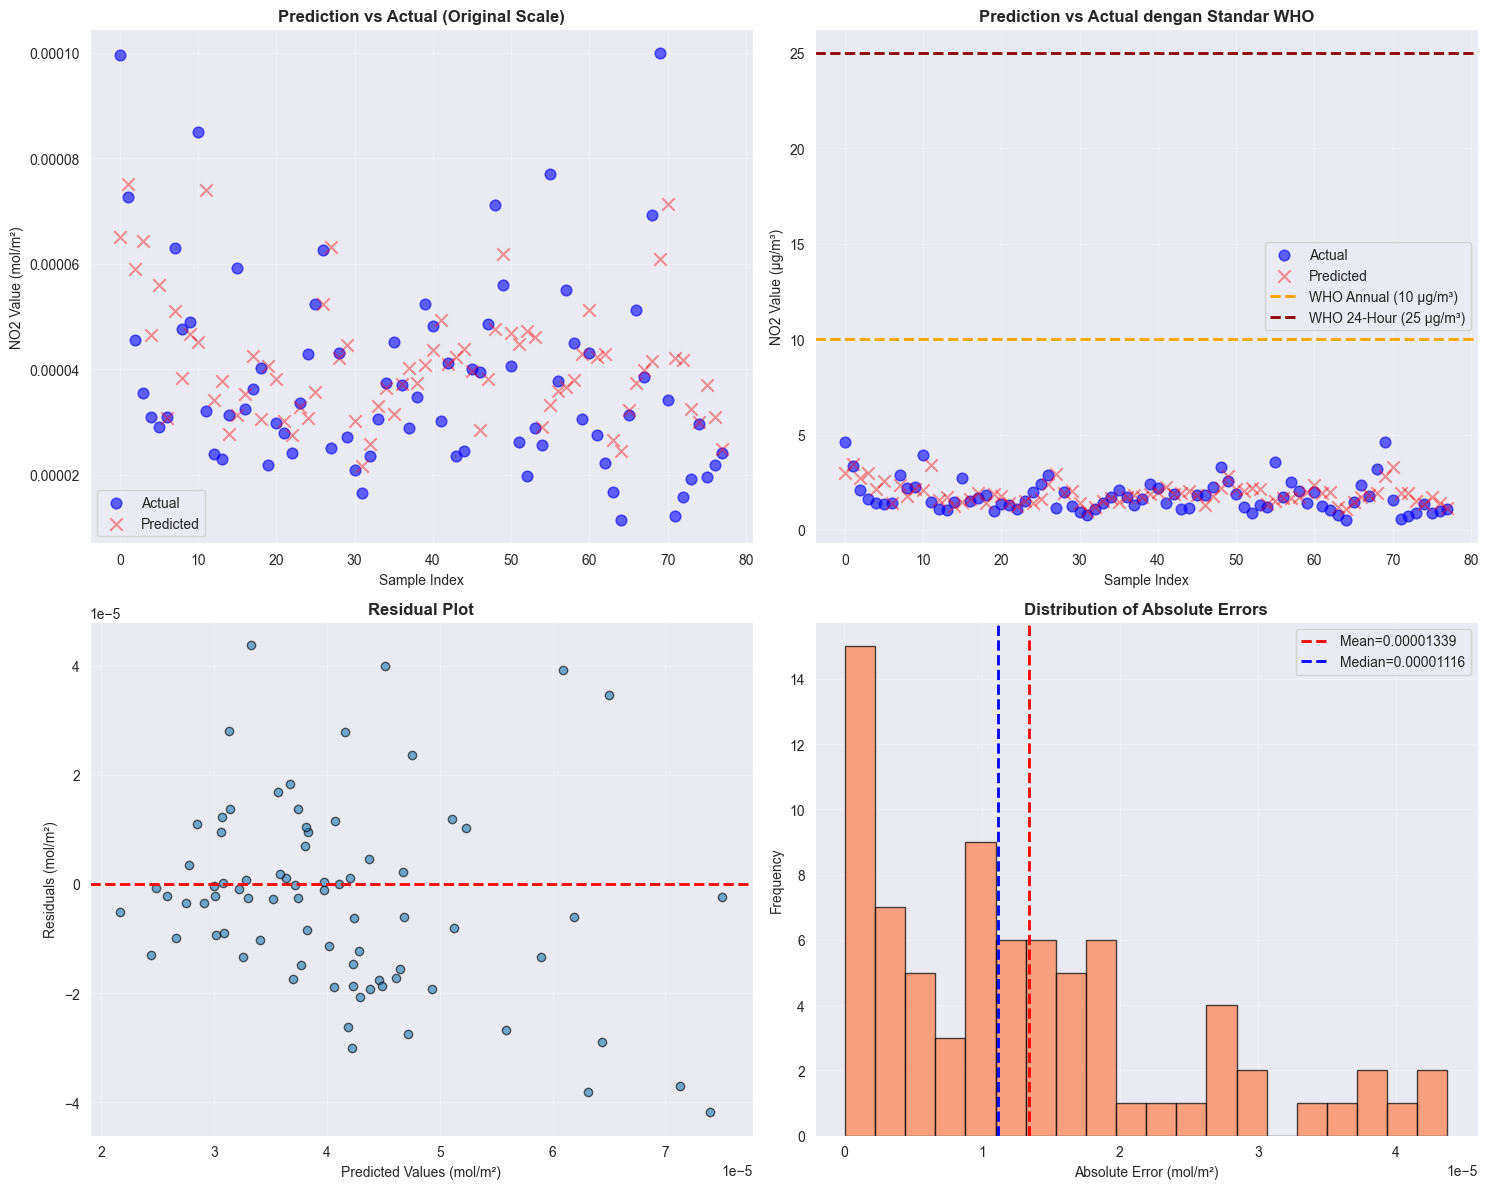

In [9]:
print("\n" + "="*70)
print("LANGKAH 7: EVALUASI REGRESSION DENGAN STANDAR WHO")
print("="*70)

# Train final model dengan best K (menggunakan data yang sudah dinormalisasi)
best_k = int(best_k)
final_model = KNeighborsRegressor(n_neighbors=best_k, metric='euclidean')
final_model.fit(X_train_scaled, y_train)

# SIMPAN MODEL untuk digunakan saat implementasi/deployment
model_filename = 'knn_model.pkl'
joblib.dump(final_model, model_filename)
print(f"\n✓ Model berhasil disimpan ke: {model_filename}")
print(f"  → Model ini akan digunakan untuk prediksi data baru saat deployment")

# Prediksi nilai NO2 (continuous)
y_pred_regression = final_model.predict(X_test_scaled)

# Hitung metrics regression
mse = mean_squared_error(y_test, y_pred_regression)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_regression)
r2 = r2_score(y_test, y_pred_regression)

# Hitung MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test - y_pred_regression) / y_test)) * 100

print(f"\n[A] REGRESSION METRICS (K={best_k}):")
print(f"  - MSE:  {mse:.10f}")
print(f"  - RMSE: {rmse:.10f}")
print(f"  - MAE:  {mae:.10f}")
print(f"  - MAPE: {mape:.2f}%")
print(f"  - R²:   {r2:.4f}")

# Interpretasi MAPE
print(f"\n[INTERPRETASI MAPE]:")
if mape < 10:
    print(f"  ✓ MAPE < 10%: Model SANGAT BAIK (Highly Accurate)")
elif mape < 20:
    print(f"  ✓ MAPE 10-20%: Model BAIK (Good Forecasting)")
elif mape < 50:
    print(f"  ⚠ MAPE 20-50%: Model CUKUP (Reasonable Forecasting)")
else:
    print(f"  ✗ MAPE > 50%: Model KURANG BAIK (Inaccurate Forecasting)")

# Konversi ke µg/m³ (aproksimasi sederhana)
# Formula: µg/m³ ≈ (mol/m² × 46.01 × 10⁶) / 1000
# Simplifikasi: µg/m³ ≈ mol/m² × 46010
CONVERSION_FACTOR = 46010

y_test_ugm3 = y_test * CONVERSION_FACTOR
y_pred_ugm3 = y_pred_regression * CONVERSION_FACTOR

# Standar WHO
WHO_ANNUAL = 10  # µg/m³
WHO_24HOUR = 25  # µg/m³

print(f"\n[B] KONVERSI KE µg/m³ DAN PERBANDINGAN WHO:")
print(f"  - Conversion factor: {CONVERSION_FACTOR}")
print(f"  - Test set range: [{y_test_ugm3.min():.2f}, {y_test_ugm3.max():.2f}] µg/m³")
print(f"  - Predicted range: [{y_pred_ugm3.min():.2f}, {y_pred_ugm3.max():.2f}] µg/m³")
print(f"\n  - WHO Annual Standard: {WHO_ANNUAL} µg/m³")
print(f"  - WHO 24-Hour Standard: {WHO_24HOUR} µg/m³")

# Hitung statistik perbandingan dengan WHO
test_above_annual = (y_test_ugm3 > WHO_ANNUAL).sum()
test_above_24hour = (y_test_ugm3 > WHO_24HOUR).sum()
pred_above_annual = (y_pred_ugm3 > WHO_ANNUAL).sum()
pred_above_24hour = (y_pred_ugm3 > WHO_24HOUR).sum()

print(f"\n[C] ANALISIS TERHADAP STANDAR WHO (Test Set):")
print(f"  Actual:")
print(f"    - Di atas WHO Annual (10 µg/m³): {test_above_annual}/{len(y_test)} ({test_above_annual/len(y_test)*100:.1f}%)")
print(f"    - Di atas WHO 24-Hour (25 µg/m³): {test_above_24hour}/{len(y_test)} ({test_above_24hour/len(y_test)*100:.1f}%)")
print(f"  Predicted:")
print(f"    - Di atas WHO Annual (10 µg/m³): {pred_above_annual}/{len(y_pred_regression)} ({pred_above_annual/len(y_pred_regression)*100:.1f}%)")
print(f"    - Di atas WHO 24-Hour (25 µg/m³): {pred_above_24hour}/{len(y_pred_regression)} ({pred_above_24hour/len(y_pred_regression)*100:.1f}%)")

# Visualisasi
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Actual vs Predicted (mol/m²)
axes[0, 0].scatter(range(len(y_test)), y_test, alpha=0.6, label='Actual', s=60, color='blue')
axes[0, 0].scatter(range(len(y_pred_regression)), y_pred_regression, alpha=0.4, label='Predicted', marker='x', s=80, color='red')
axes[0, 0].set_xlabel('Sample Index')
axes[0, 0].set_ylabel('NO2 Value (mol/m²)')
axes[0, 0].set_title('Prediction vs Actual (Original Scale)', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Actual vs Predicted dengan WHO Standards (µg/m³)
axes[0, 1].scatter(range(len(y_test_ugm3)), y_test_ugm3, alpha=0.6, label='Actual', s=60, color='blue')
axes[0, 1].scatter(range(len(y_pred_ugm3)), y_pred_ugm3, alpha=0.4, label='Predicted', marker='x', s=80, color='red')
axes[0, 1].axhline(y=WHO_ANNUAL, color='orange', linestyle='--', linewidth=2, label=f'WHO Annual ({WHO_ANNUAL} µg/m³)')
axes[0, 1].axhline(y=WHO_24HOUR, color='darkred', linestyle='--', linewidth=2, label=f'WHO 24-Hour ({WHO_24HOUR} µg/m³)')
axes[0, 1].set_xlabel('Sample Index')
axes[0, 1].set_ylabel('NO2 Value (µg/m³)')
axes[0, 1].set_title('Prediction vs Actual dengan Standar WHO', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Residual Plot
residuals = y_test - y_pred_regression
axes[1, 0].scatter(y_pred_regression, residuals, alpha=0.6, edgecolors='k')
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted Values (mol/m²)')
axes[1, 0].set_ylabel('Residuals (mol/m²)')
axes[1, 0].set_title('Residual Plot', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Error Distribution
errors = np.abs(y_test - y_pred_regression)
axes[1, 1].hist(errors, bins=20, edgecolor='black', alpha=0.7, color='coral')
axes[1, 1].axvline(x=np.mean(errors), color='red', linestyle='--', linewidth=2, label=f'Mean={np.mean(errors):.8f}')
axes[1, 1].axvline(x=np.median(errors), color='blue', linestyle='--', linewidth=2, label=f'Median={np.median(errors):.8f}')
axes[1, 1].set_xlabel('Absolute Error (mol/m²)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Absolute Errors', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## LANGKAH 8: Visualization - Prediction Analysis

**Kategori: MODELLING (Evaluation & Analysis)**

**Tujuan**: Analisis mendalam terhadap hasil prediksi model

**Visualisasi**:
1. **Error Distribution**: Histogram error absolut
2. **Prediction vs Actual dengan Kategori**: Scatter plot dengan warna
3. **Binary Classification Result**: Bar chart perbandingan
4. **Percentage Error**: Analisis error relatif


LANGKAH 8: VISUALIZATION - PREDICTION ANALYSIS

Error Analysis:
  - Mean Absolute Error: 0.00001339
  - Median Absolute Error: 0.00001116
  - Max Error: 0.00004372
  - Min Error: 0.00000008


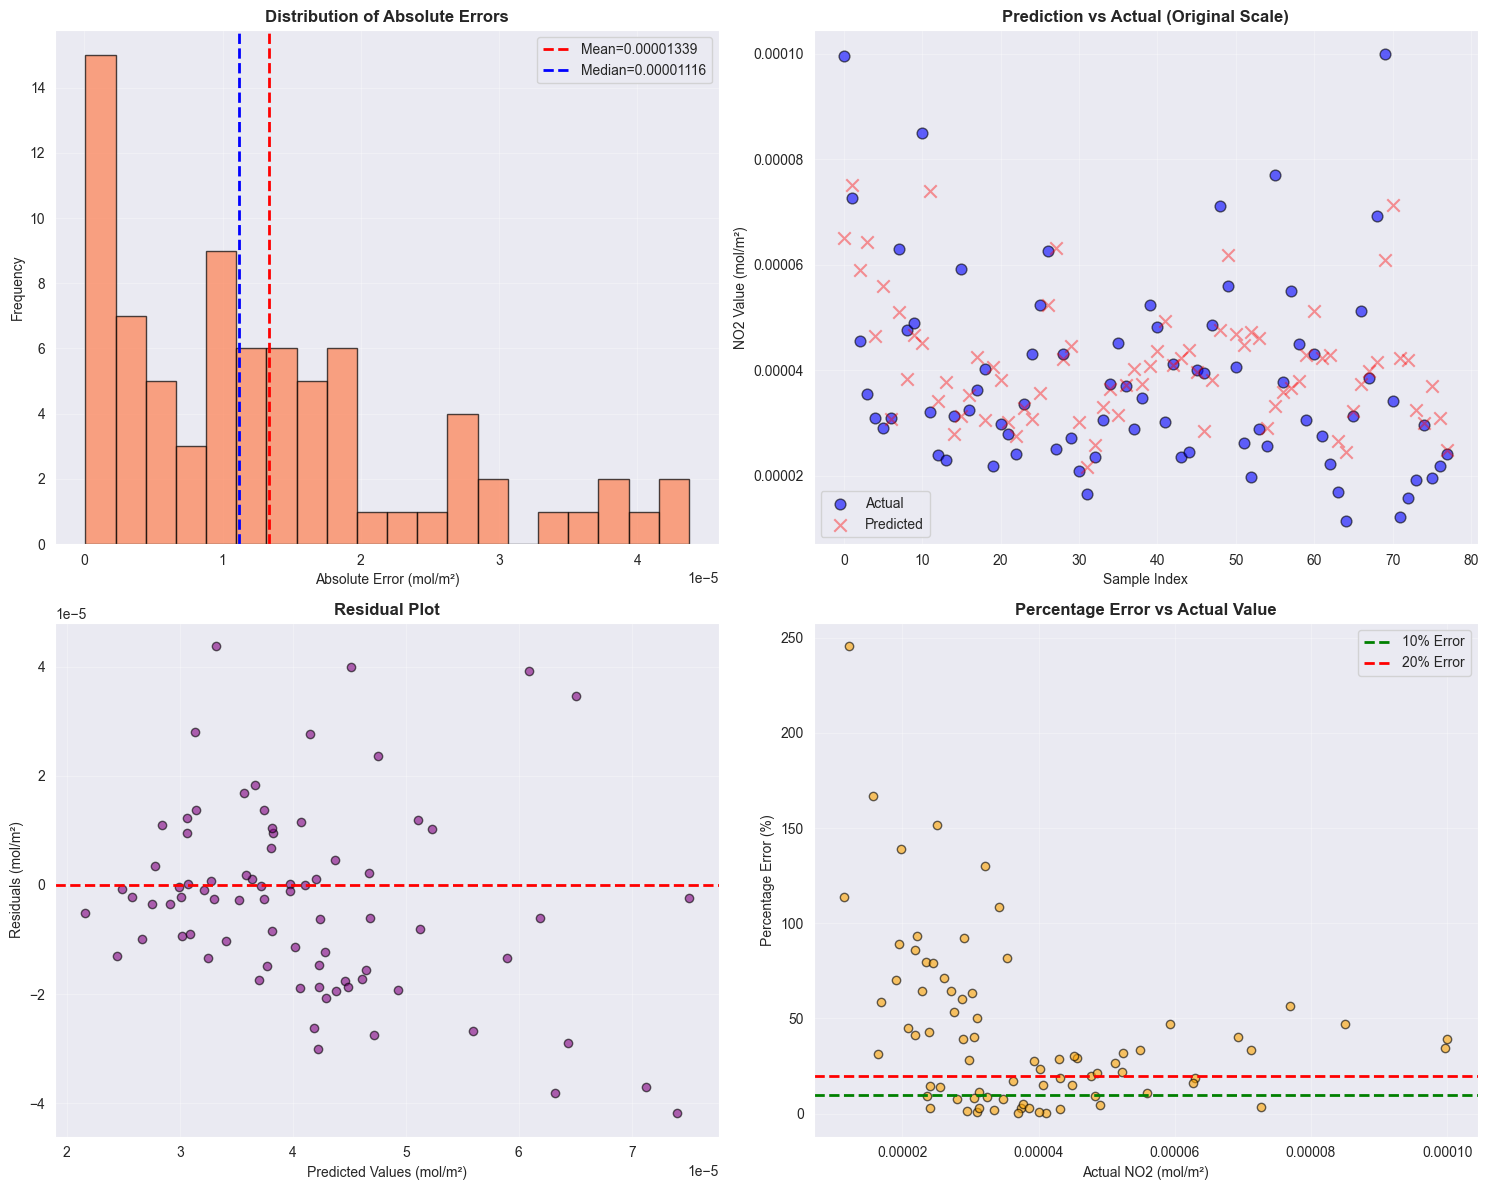


Visualisasi selesai


In [10]:
print("\n" + "="*70)
print("LANGKAH 8: VISUALIZATION - PREDICTION ANALYSIS")
print("="*70)

# Analisis error distribution
errors = np.abs(y_test - y_pred_regression)
mean_error = np.mean(errors)
median_error = np.median(errors)

print(f"\nError Analysis:")
print(f"  - Mean Absolute Error: {mean_error:.8f}")
print(f"  - Median Absolute Error: {median_error:.8f}")
print(f"  - Max Error: {errors.max():.8f}")
print(f"  - Min Error: {errors.min():.8f}")

# Visualisasi
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Error Distribution
axes[0, 0].hist(errors, bins=20, edgecolor='black', alpha=0.7, color='coral')
axes[0, 0].axvline(x=mean_error, color='red', linestyle='--', linewidth=2, label=f'Mean={mean_error:.8f}')
axes[0, 0].axvline(x=median_error, color='blue', linestyle='--', linewidth=2, label=f'Median={median_error:.8f}')
axes[0, 0].set_xlabel('Absolute Error (mol/m²)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Absolute Errors', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Prediction vs Actual (mol/m²)
axes[0, 1].scatter(range(len(y_test)), y_test, alpha=0.6, label='Actual', s=60, color='blue', edgecolors='k')
axes[0, 1].scatter(range(len(y_pred_regression)), y_pred_regression, alpha=0.4, label='Predicted', marker='x', s=80, color='red')
axes[0, 1].set_xlabel('Sample Index')
axes[0, 1].set_ylabel('NO2 Value (mol/m²)')
axes[0, 1].set_title('Prediction vs Actual (Original Scale)', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Residual Plot
residuals = y_test - y_pred_regression
axes[1, 0].scatter(y_pred_regression, residuals, alpha=0.6, edgecolors='k', color='purple')
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted Values (mol/m²)')
axes[1, 0].set_ylabel('Residuals (mol/m²)')
axes[1, 0].set_title('Residual Plot', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Percentage Error
percentage_error = (errors / y_test) * 100
axes[1, 1].scatter(y_test, percentage_error, alpha=0.6, edgecolors='k', color='orange')
axes[1, 1].axhline(y=10, color='green', linestyle='--', linewidth=2, label='10% Error')
axes[1, 1].axhline(y=20, color='red', linestyle='--', linewidth=2, label='20% Error')
axes[1, 1].set_xlabel('Actual NO2 (mol/m²)')
axes[1, 1].set_ylabel('Percentage Error (%)')
axes[1, 1].set_title('Percentage Error vs Actual Value', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nVisualisasi selesai")

---

## LANGKAH 9: Prediksi Nilai NO2 Satu Hari Ke Depan

**Kategori: MODELLING (Deployment/Application)**

**Tujuan**: Gunakan model untuk prediksi NO₂ satu hari ke depan dan bandingkan dengan standar WHO

**Proses**:
1. Ambil 5 hari terakhir dari data (NO2(t-5), NO2(t-4), NO2(t-3), NO2(t-2), NO2(t-1))
2. Normalisasi dengan scaler yang sudah di-fit
3. **Prediksi nilai NO₂** menggunakan final model
4. **Konversi ke µg/m³** untuk perbandingan dengan WHO
5. **Analisis**: Bandingkan dengan standar WHO (10 µg/m³ annual, 25 µg/m³ 24-hour)
6. **Visualisasi prediksi** dengan bar chart

---


LANGKAH 9: PREDIKSI NILAI NO2 SATU HARI KE DEPAN

Data 5 hari terakhir (Original):
  - NO2(t-5): 0.00001567 mol/m²
  - NO2(t-4): 0.00001912 mol/m²
  - NO2(t-3): 0.00002953 mol/m²
  - NO2(t-2): 0.00001956 mol/m²
  - NO2(t-1): 0.00002184 mol/m²

Data 5 hari terakhir (Normalized):
  - NO2(t-5): 0.0816
  - NO2(t-4): 0.1097
  - NO2(t-3): 0.1944
  - NO2(t-2): 0.1133
  - NO2(t-1): 0.1318

HASIL PREDIKSI NO2 HARI BESOK (SATU HARI KE DEPAN)

[A] PREDIKSI NILAI NO2:
  - Predicted NO2: 0.00002484 mol/m²
  - Predicted NO2: 1.14 µg/m³

[B] PERBANDINGAN DENGAN STANDAR WHO:
  - WHO Annual Standard: 10 µg/m³
  - WHO 24-Hour Standard: 25 µg/m³

[C] ANALISIS:
  ✓ SANGAT BAIK: NO₂ prediksi (1.14 µg/m³) di bawah WHO Annual Standard
    → 8.86 µg/m³ di bawah batas (11.4% dari batas)


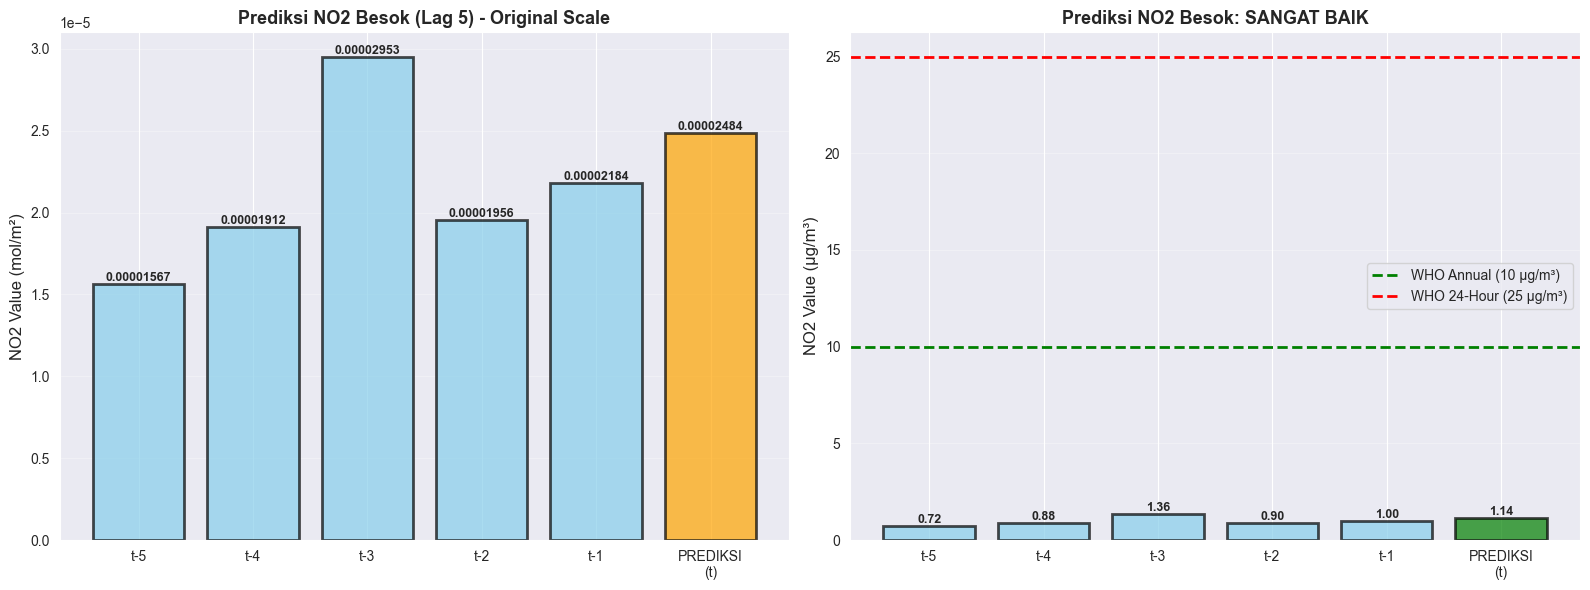

In [11]:
print("\n" + "="*70)
print("LANGKAH 9: PREDIKSI NILAI NO2 SATU HARI KE DEPAN")
print("="*70)

# Ambil 5 hari terakhir dari supervised_df (data asli)
last_5_days_original = supervised_df[["NO2(t-5)", "NO2(t-4)", "NO2(t-3)", "NO2(t-2)", "NO2(t-1)"]].iloc[-1].values

print(f"\nData 5 hari terakhir (Original):")
print(f"  - NO2(t-5): {last_5_days_original[0]:.8f} mol/m²")
print(f"  - NO2(t-4): {last_5_days_original[1]:.8f} mol/m²")
print(f"  - NO2(t-3): {last_5_days_original[2]:.8f} mol/m²")
print(f"  - NO2(t-2): {last_5_days_original[3]:.8f} mol/m²")
print(f"  - NO2(t-1): {last_5_days_original[4]:.8f} mol/m²")

# Normalisasi
last_5_days_scaled = scaler.transform([last_5_days_original])[0]

print(f"\nData 5 hari terakhir (Normalized):")
print(f"  - NO2(t-5): {last_5_days_scaled[0]:.4f}")
print(f"  - NO2(t-4): {last_5_days_scaled[1]:.4f}")
print(f"  - NO2(t-3): {last_5_days_scaled[2]:.4f}")
print(f"  - NO2(t-2): {last_5_days_scaled[3]:.4f}")
print(f"  - NO2(t-1): {last_5_days_scaled[4]:.4f}")

# Reshape untuk input model
X_tomorrow = last_5_days_scaled.reshape(1, -1)

# Prediksi nilai NO2 (regression)
pred_no2_value = final_model.predict(X_tomorrow)[0]

# Konversi ke µg/m³
pred_no2_ugm3 = pred_no2_value * CONVERSION_FACTOR

# Standar WHO
WHO_ANNUAL = 10  # µg/m³
WHO_24HOUR = 25  # µg/m³

print("\n" + "="*70)
print("HASIL PREDIKSI NO2 HARI BESOK (SATU HARI KE DEPAN)")
print("="*70)

print(f"\n[A] PREDIKSI NILAI NO2:")
print(f"  - Predicted NO2: {pred_no2_value:.8f} mol/m²")
print(f"  - Predicted NO2: {pred_no2_ugm3:.2f} µg/m³")

print(f"\n[B] PERBANDINGAN DENGAN STANDAR WHO:")
print(f"  - WHO Annual Standard: {WHO_ANNUAL} µg/m³")
print(f"  - WHO 24-Hour Standard: {WHO_24HOUR} µg/m³")

# Analisis terhadap standar WHO
print(f"\n[C] ANALISIS:")
if pred_no2_ugm3 <= WHO_ANNUAL:
    diff_annual = WHO_ANNUAL - pred_no2_ugm3
    pct_annual = (pred_no2_ugm3 / WHO_ANNUAL) * 100
    print(f"  ✓ SANGAT BAIK: NO₂ prediksi ({pred_no2_ugm3:.2f} µg/m³) di bawah WHO Annual Standard")
    print(f"    → {diff_annual:.2f} µg/m³ di bawah batas ({pct_annual:.1f}% dari batas)")
elif pred_no2_ugm3 <= WHO_24HOUR:
    diff_annual = pred_no2_ugm3 - WHO_ANNUAL
    diff_24hour = WHO_24HOUR - pred_no2_ugm3
    pct_annual = ((pred_no2_ugm3 - WHO_ANNUAL) / WHO_ANNUAL) * 100
    print(f"  ⚠ PERHATIAN: NO₂ prediksi ({pred_no2_ugm3:.2f} µg/m³) di atas WHO Annual Standard")
    print(f"    → {diff_annual:.2f} µg/m³ di atas batas annual (+{pct_annual:.1f}%)")
    print(f"    → Masih {diff_24hour:.2f} µg/m³ di bawah WHO 24-Hour Standard")
    print(f"    → Perlu monitoring untuk jangka panjang")
else:
    diff_24hour = pred_no2_ugm3 - WHO_24HOUR
    pct_24hour = ((pred_no2_ugm3 - WHO_24HOUR) / WHO_24HOUR) * 100
    print(f"  ✗ BERBAHAYA: NO₂ prediksi ({pred_no2_ugm3:.2f} µg/m³) di atas WHO 24-Hour Standard")
    print(f"    → {diff_24hour:.2f} µg/m³ di atas batas 24-hour (+{pct_24hour:.1f}%)")
    print(f"    → PERINGATAN TINGGI: Kualitas udara buruk!")
    print(f"    → Diperlukan tindakan mitigasi segera")

# Visualisasi prediksi
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Prediksi dalam mol/m²
days = ['t-5', 't-4', 't-3', 't-2', 't-1', 'PREDIKSI\n(t)']
values_mol = list(last_5_days_original) + [pred_no2_value]
colors_bar = ['skyblue'] * 5 + ['orange']

bars1 = axes[0].bar(days, values_mol, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_ylabel('NO2 Value (mol/m²)', fontsize=12)
axes[0].set_title('Prediksi NO2 Besok (Lag 5) - Original Scale', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Tambah label nilai di atas bar
for bar, val in zip(bars1, values_mol):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.8f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 2: Prediksi dalam µg/m³ dengan standar WHO
values_ugm3 = [v * CONVERSION_FACTOR for v in last_5_days_original] + [pred_no2_ugm3]

# Tentukan warna berdasarkan standar WHO
if pred_no2_ugm3 <= WHO_ANNUAL:
    color_pred = 'green'
    status_text = 'SANGAT BAIK'
elif pred_no2_ugm3 <= WHO_24HOUR:
    color_pred = 'orange'
    status_text = 'PERHATIAN'
else:
    color_pred = 'red'
    status_text = 'BERBAHAYA'

colors_bar2 = ['skyblue'] * 5 + [color_pred]

bars2 = axes[1].bar(days, values_ugm3, color=colors_bar2, alpha=0.7, edgecolor='black', linewidth=2)
axes[1].axhline(y=WHO_ANNUAL, color='green', linestyle='--', linewidth=2, label=f'WHO Annual ({WHO_ANNUAL} µg/m³)')
axes[1].axhline(y=WHO_24HOUR, color='red', linestyle='--', linewidth=2, label=f'WHO 24-Hour ({WHO_24HOUR} µg/m³)')
axes[1].set_ylabel('NO2 Value (µg/m³)', fontsize=12)
axes[1].set_title(f'Prediksi NO2 Besok: {status_text}', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

# Tambah label nilai di atas bar
for bar, val in zip(bars2, values_ugm3):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.2f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*70)

---

## IMPLEMENTASI MODEL (Deployment)

**Kategori: DEPLOYMENT**

**Tujuan**: Menunjukkan cara menggunakan model dan scaler yang tersimpan untuk prediksi data baru

**File yang Diperlukan**:
1. `knn_model.pkl` - Model KNN yang sudah dilatih
2. `minmax_scaler.pkl` - Scaler yang sudah di-fit pada training set
3. `threshold` - Nilai threshold untuk klasifikasi

**Proses**:
1. Load model dan scaler yang tersimpan
2. Normalisasi data baru menggunakan scaler tersebut
3. Prediksi menggunakan model
4. Klasifikasi berdasarkan threshold


In [12]:
print("\n" + "="*70)
print("CONTOH IMPLEMENTASI: PREDIKSI DENGAN DATA BARU")
print("="*70)

# SIMULASI: Misalkan kita punya data NO2 baru (5 hari terakhir)
# Dalam praktik, data ini bisa berasal dari database atau API real-time
data_baru = np.array([[0.00012, 0.00015, 0.00018, 0.00020, 0.00022]])  # Contoh: NO2(t-5), NO2(t-4), NO2(t-3), NO2(t-2), NO2(t-1)

print(f"\n[1] DATA BARU (belum dinormalisasi):")
print(f"    NO2(t-5): {data_baru[0, 0]:.8f} mol/m²")
print(f"    NO2(t-4): {data_baru[0, 1]:.8f} mol/m²")
print(f"    NO2(t-3): {data_baru[0, 2]:.8f} mol/m²")
print(f"    NO2(t-2): {data_baru[0, 3]:.8f} mol/m²")
print(f"    NO2(t-1): {data_baru[0, 4]:.8f} mol/m²")

# LANGKAH 1: Load scaler yang tersimpan
print(f"\n[2] LOAD SCALER dari file:")
loaded_scaler = joblib.load('minmax_scaler.pkl')
print(f"    ✓ Scaler berhasil di-load dari: minmax_scaler.pkl")
print(f"    ✓ Scaler parameter (min): {loaded_scaler.data_min_}")
print(f"    ✓ Scaler parameter (max): {loaded_scaler.data_max_}")

# LANGKAH 2: Load model yang tersimpan
print(f"\n[3] LOAD MODEL dari file:")
loaded_model = joblib.load('knn_model.pkl')
print(f"    ✓ Model berhasil di-load dari: knn_model.pkl")
print(f"    ✓ Model type: {type(loaded_model).__name__}")
print(f"    ✓ Model parameters: {loaded_model.get_params()}")

# LANGKAH 3: Normalisasi data baru menggunakan scaler yang tersimpan
data_baru_normalized = loaded_scaler.transform(data_baru)
print(f"\n[4] NORMALISASI DATA BARU:")
print(f"    NO2(t-5) normalized: {data_baru_normalized[0, 0]:.4f}")
print(f"    NO2(t-4) normalized: {data_baru_normalized[0, 1]:.4f}")
print(f"    NO2(t-3) normalized: {data_baru_normalized[0, 2]:.4f}")
print(f"    NO2(t-2) normalized: {data_baru_normalized[0, 3]:.4f}")
print(f"    NO2(t-1) normalized: {data_baru_normalized[0, 4]:.4f}")

# LANGKAH 4: Prediksi menggunakan model
prediksi_no2 = loaded_model.predict(data_baru_normalized)[0]
prediksi_no2_ugm3 = prediksi_no2 * CONVERSION_FACTOR

print(f"\n[5] PREDIKSI NO2 HARI BESOK:")
print(f"    Predicted NO2: {prediksi_no2:.8f} mol/m²")
print(f"    Predicted NO2: {prediksi_no2_ugm3:.2f} µg/m³")

# LANGKAH 5: Bandingkan dengan standar WHO
WHO_ANNUAL = 10  # µg/m³
WHO_24HOUR = 25  # µg/m³

print(f"\n[6] PERBANDINGAN DENGAN STANDAR WHO:")
print(f"    WHO Annual Standard: {WHO_ANNUAL} µg/m³")
print(f"    WHO 24-Hour Standard: {WHO_24HOUR} µg/m³")

if prediksi_no2_ugm3 <= WHO_ANNUAL:
    diff = WHO_ANNUAL - prediksi_no2_ugm3
    print(f"    ✓ Status: SANGAT BAIK")
    print(f"    → {diff:.2f} µg/m³ di bawah WHO Annual Standard")
elif prediksi_no2_ugm3 <= WHO_24HOUR:
    diff_annual = prediksi_no2_ugm3 - WHO_ANNUAL
    diff_24hour = WHO_24HOUR - prediksi_no2_ugm3
    print(f"    ⚠ Status: PERHATIAN")
    print(f"    → {diff_annual:.2f} µg/m³ di atas WHO Annual Standard")
    print(f"    → {diff_24hour:.2f} µg/m³ di bawah WHO 24-Hour Standard")
else:
    diff = prediksi_no2_ugm3 - WHO_24HOUR
    print(f"    ✗ Status: BERBAHAYA")
    print(f"    → {diff:.2f} µg/m³ di atas WHO 24-Hour Standard")
    print(f"    → PERINGATAN: Kualitas udara buruk!")


CONTOH IMPLEMENTASI: PREDIKSI DENGAN DATA BARU

[1] DATA BARU (belum dinormalisasi):
    NO2(t-5): 0.00012000 mol/m²
    NO2(t-4): 0.00015000 mol/m²
    NO2(t-3): 0.00018000 mol/m²
    NO2(t-2): 0.00020000 mol/m²
    NO2(t-1): 0.00022000 mol/m²

[2] LOAD SCALER dari file:
    ✓ Scaler berhasil di-load dari: minmax_scaler.pkl
    ✓ Scaler parameter (min): [5.63569029e-06 5.63569029e-06 5.63569029e-06 5.63569029e-06
 5.63569029e-06]
    ✓ Scaler parameter (max): [0.00012854 0.00012854 0.00012854 0.00012854 0.00012854]

[3] LOAD MODEL dari file:
    ✓ Model berhasil di-load dari: knn_model.pkl
    ✓ Model type: KNeighborsRegressor
    ✓ Model parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}

[4] NORMALISASI DATA BARU:
    NO2(t-5) normalized: 0.9305
    NO2(t-4) normalized: 1.1746
    NO2(t-3) normalized: 1.4187
    NO2(t-2) normalized: 1.5814
    NO2(t-1) normalized: 1.7441

[


DEPLOYMENT : PREDIKSI DATA BARU

[KONVERSI] Faktor konversi mol/m² ke µg/m³: 46010
  Formula: µg/m³ = mol/m² × 46010

[INPUT DATA ] Masukkan nilai NO2 dari 5 hari terakhir
----------------------------------------------------------------------
Format: gunakan notasi desimal (contoh: 0.00011)
Satuan: mol/m²


[SUCCESS] Data berhasil diinput!

Ringkasan data yang dimasukkan:
  NO2(t-5): 0.00000400 mol/m²
  NO2(t-4): 0.00000500 mol/m²
  NO2(t-3): 0.00000300 mol/m²
  NO2(t-2): 0.00000600 mol/m²
  NO2(t-1): 0.00000100 mol/m²

LANGKAH 1: LOAD SCALER
[SUCCESS] Scaler berhasil di-load dari: minmax_scaler.pkl

[INFO SCALER]
  Scaler ini sudah di-FIT pada training data dengan statistik:
  - Data Min (dari training): [5.63569029e-06 5.63569029e-06 5.63569029e-06 5.63569029e-06
 5.63569029e-06]
  - Data Max (dari training): [0.00012854 0.00012854 0.00012854 0.00012854 0.00012854]
  - Data Range (dari training): [0.00012291 0.00012291 0.00012291 0.00012291 0.00012291]

  [PENTING] Scaler ini akan T

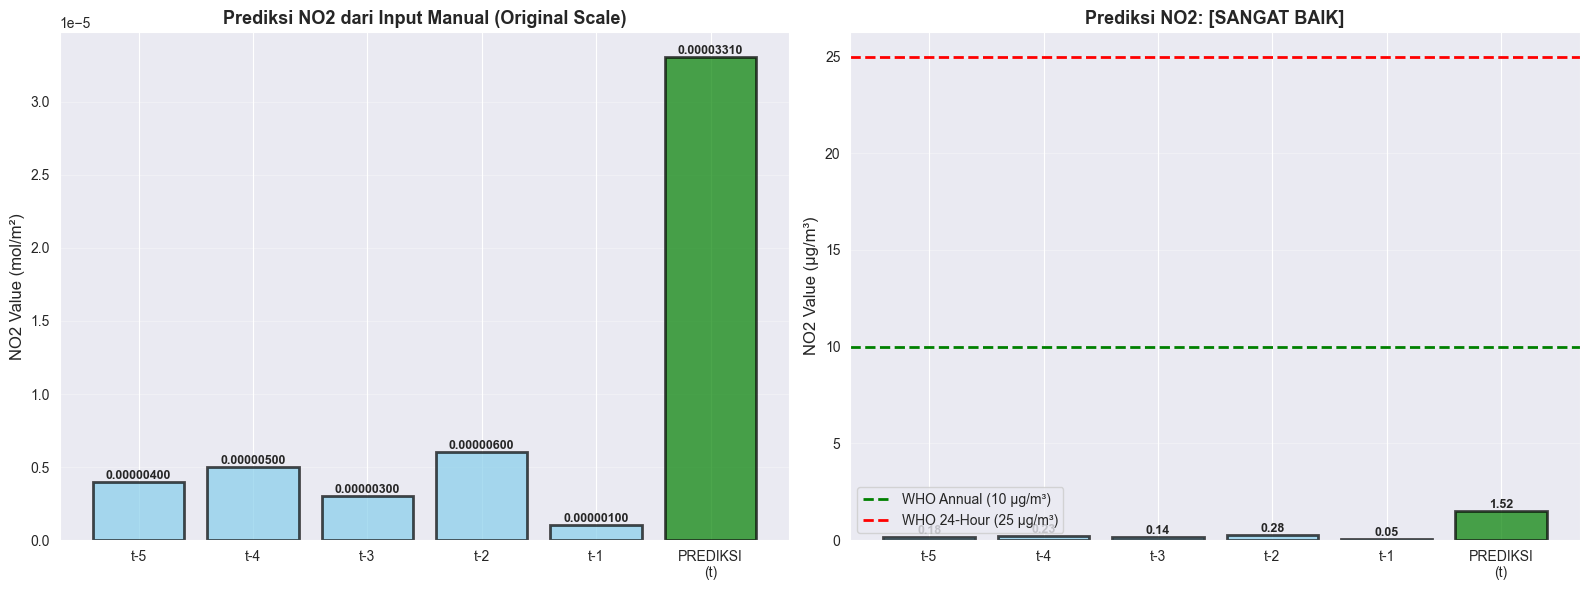


RINGKASAN DEPLOYMENT

INPUT (Data Manual dari Pengguna):
  - NO2(t-5): 0.00000400 mol/m²
  - NO2(t-4): 0.00000500 mol/m²
  - NO2(t-3): 0.00000300 mol/m²
  - NO2(t-2): 0.00000600 mol/m²
  - NO2(t-1): 0.00000100 mol/m²

PROSES:
  [1] Input data manual dari pengguna [OK]
  [2] Load scaler (fit pada training) [OK]
  [3] Transform data baru (BUKAN fit!) [OK]
  [4] Load model [OK]
  [5] Prediksi → 0.00003310 mol/m² [OK]
  [6] Konversi → 1.52 µg/m³ [OK]
  [7] Bandingkan WHO → [SANGAT BAIK] [OK]

OUTPUT (Prediksi):
  - Nilai: 0.00003310 mol/m² atau 1.52 µg/m³
  - Status: [SANGAT BAIK]




In [ ]:
print("\n" + "="*70)
print("DEPLOYMENT : PREDIKSI DATA BARU")
print("="*70)

# ============================================================================
# DEFINISI CONVERSION FACTOR (PENTING!)
# ============================================================================
# Formula: µg/m³ ≈ (mol/m² × 46.01 × 10⁶) / 1000
# Simplifikasi: µg/m³ ≈ mol/m² × 46010
CONVERSION_FACTOR = 46010

print(f"\n[KONVERSI] Faktor konversi mol/m² ke µg/m³: {CONVERSION_FACTOR}")
print(f"  Formula: µg/m³ = mol/m² × {CONVERSION_FACTOR}")

# ============================================================================
# INPUT DATA : Meminta pengguna memasukkan data NO2 dari 5 hari terakhir
# ============================================================================
print("\n[INPUT DATA ] Masukkan nilai NO2 dari 5 hari terakhir")
print("-"*70)
print("Format: gunakan notasi desimal (contoh: 0.00011)")
print("Satuan: mol/m²\n")

# Inisialisasi list untuk menyimpan input
data_input = []

# Loop untuk meminta input 5 hari
for i in range(5, 0, -1):
    while True:
        try:
            nilai = input(f"NO2(t-{i}): ")
            nilai_float = float(nilai)
            
            # Validasi: nilai harus positif dan dalam range wajar
            if nilai_float < 0:
                print("  [ERROR] Nilai tidak boleh negatif! Coba lagi.")
                continue
            if nilai_float > 0.01:
                print(f"  [PERINGATAN] Nilai {nilai_float} mol/m² sangat tinggi!")
                konfirmasi = input("  Lanjutkan? (y/n): ")
                if konfirmasi.lower() != 'y':
                    continue
            
            data_input.append(nilai_float)
            break
        except ValueError:
            print("  [ERROR] Input harus berupa angka! Coba lagi.")
        except Exception as e:
            print(f"  [ERROR] {str(e)}")

# Konversi ke numpy array
data_baru_deployment = np.array([data_input])

print(f"\n[SUCCESS] Data berhasil diinput!")
print(f"\nRingkasan data yang dimasukkan:")
for i in range(5):
    print(f"  NO2(t-{5-i}): {data_baru_deployment[0, i]:.8f} mol/m²")

# ============================================================================
# LANGKAH 1: LOAD SCALER (yang sudah di-fit pada training data)
# ============================================================================
print("\n" + "="*70)
print("LANGKAH 1: LOAD SCALER")
print("="*70)

scaler_deploy = joblib.load('minmax_scaler.pkl')

print(f"[SUCCESS] Scaler berhasil di-load dari: minmax_scaler.pkl")
print(f"\n[INFO SCALER]")
print(f"  Scaler ini sudah di-FIT pada training data dengan statistik:")
print(f"  - Data Min (dari training): {scaler_deploy.data_min_}")
print(f"  - Data Max (dari training): {scaler_deploy.data_max_}")
print(f"  - Data Range (dari training): {scaler_deploy.data_range_}")
print(f"\n  [PENTING] Scaler ini akan TRANSFORM data baru menggunakan")
print(f"            parameter min/max dari TRAINING SET (bukan dari data baru!)")

# ============================================================================
# LANGKAH 2: NORMALISASI DATA BARU 
# ============================================================================
print("\n" + "="*70)
print("LANGKAH 2: NORMALISASI DATA BARU")
print("="*70)

# HANYA TRANSFORM (jangan fit lagi!)
data_baru_scaled = scaler_deploy.transform(data_baru_deployment)

print(f"Proses: scaler.transform(data_baru)")


print(f"Hasil normalisasi [0, 1]:")
for i in range(5):
    original = data_baru_deployment[0, i]
    scaled = data_baru_scaled[0, i]
    print(f"  NO2(t-{5-i}): {original:.8f} → {scaled:.4f}")

# Verifikasi normalisasi manual (untuk pemahaman)
print(f"\n[VERIFIKASI MANUAL]")
print(f"Formula: (x - min) / (max - min)")
for i in range(5):
    manual_scaled = (data_baru_deployment[0, i] - scaler_deploy.data_min_[i]) / scaler_deploy.data_range_[i]
    print(f"  Feature {i}: (x - {scaler_deploy.data_min_[i]:.8f}) / {scaler_deploy.data_range_[i]:.8f} = {manual_scaled:.4f}")

# ============================================================================
# LANGKAH 3: LOAD MODEL
# ============================================================================
print("\n" + "="*70)
print("LANGKAH 3: LOAD MODEL")
print("="*70)

model_deploy = joblib.load('knn_model.pkl')

print(f"[SUCCESS] Model berhasil di-load dari: knn_model.pkl")
print(f"\n[INFO MODEL]")
print(f"  - Algorithm: {type(model_deploy).__name__}")
print(f"  - n_neighbors (K): {model_deploy.n_neighbors}")
print(f"  - metric: {model_deploy.metric}")
print(f"  - Training samples: {model_deploy.n_samples_fit_}")

# ============================================================================
# LANGKAH 4: PREDIKSI (dengan data yang sudah dinormalisasi)
# ============================================================================
print("\n" + "="*70)
print("LANGKAH 4: PREDIKSI")
print("="*70)

# Prediksi
prediksi_mol = model_deploy.predict(data_baru_scaled)[0]

print(f"Input model: {data_baru_scaled[0]} (5 features, scaled)")
print(f"Output model: {prediksi_mol:.8f} mol/m²")


print(f"\n[HASIL] Prediksi: {prediksi_mol:.8f} mol/m² (sudah skala asli!)")

# ============================================================================
# LANGKAH 5: KONVERSI KE µg/m³ (untuk perbandingan WHO)
# ============================================================================
print("\n" + "="*70)
print("LANGKAH 5: KONVERSI KE µg/m³")
print("="*70)

prediksi_ugm3 = prediksi_mol * CONVERSION_FACTOR

print(f"Formula: µg/m³ = mol/m² × {CONVERSION_FACTOR}")
print(f"Hasil: {prediksi_mol:.8f} mol/m² × {CONVERSION_FACTOR} = {prediksi_ugm3:.2f} µg/m³")

# ============================================================================
# LANGKAH 6: PERBANDINGAN DENGAN STANDAR WHO
# ============================================================================
print("\n" + "="*70)
print("LANGKAH 6: PERBANDINGAN DENGAN STANDAR WHO")
print("="*70)

WHO_ANNUAL = 10
WHO_24HOUR = 25

print(f"Standar WHO:")
print(f"  - Annual Mean: ≤ {WHO_ANNUAL} µg/m³")
print(f"  - 24-Hour Mean: ≤ {WHO_24HOUR} µg/m³")

print(f"\nHasil Prediksi: {prediksi_ugm3:.2f} µg/m³")

if prediksi_ugm3 <= WHO_ANNUAL:
    diff = WHO_ANNUAL - prediksi_ugm3
    pct = (prediksi_ugm3 / WHO_ANNUAL) * 100
    status_final = "[SANGAT BAIK]"
    warna_status = 'green'
    print(f"\n{status_final}")
    print(f"  - {diff:.2f} µg/m³ di bawah WHO Annual Standard")
    print(f"  - {pct:.1f}% dari batas WHO Annual")
    print(f"  - Kualitas udara sangat baik untuk kesehatan")
elif prediksi_ugm3 <= WHO_24HOUR:
    diff_annual = prediksi_ugm3 - WHO_ANNUAL
    diff_24hour = WHO_24HOUR - prediksi_ugm3
    pct = ((prediksi_ugm3 - WHO_ANNUAL) / WHO_ANNUAL) * 100
    status_final = "[PERHATIAN]"
    warna_status = 'orange'
    print(f"\n{status_final}")
    print(f"  - {diff_annual:.2f} µg/m³ di atas WHO Annual Standard (+{pct:.1f}%)")
    print(f"  - {diff_24hour:.2f} µg/m³ di bawah WHO 24-Hour Standard")
    print(f"  - Perlu monitoring jangka panjang")
else:
    diff = prediksi_ugm3 - WHO_24HOUR
    pct = ((prediksi_ugm3 - WHO_24HOUR) / WHO_24HOUR) * 100
    status_final = "[BERBAHAYA]"
    warna_status = 'red'
    print(f"\n{status_final}")
    print(f"  - {diff:.2f} µg/m³ di atas WHO 24-Hour Standard (+{pct:.1f}%)")
    print(f"  - PERINGATAN: Kualitas udara buruk!")
    print(f"  - Tindakan mitigasi diperlukan")

# ============================================================================
# VISUALISASI HASIL PREDIKSI
# ============================================================================
print("\n" + "="*70)
print("VISUALISASI HASIL PREDIKSI")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Prediksi dalam mol/m²
days = ['t-5', 't-4', 't-3', 't-2', 't-1', 'PREDIKSI\n(t)']
values_mol = list(data_baru_deployment[0]) + [prediksi_mol]
colors_bar = ['skyblue'] * 5 + [warna_status]

bars1 = axes[0].bar(days, values_mol, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_ylabel('NO2 Value (mol/m²)', fontsize=12)
axes[0].set_title('Prediksi NO2 dari Input Manual (Original Scale)', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Tambah label nilai di atas bar
for bar, val in zip(bars1, values_mol):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.8f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 2: Prediksi dalam µg/m³ dengan standar WHO
values_ugm3 = [v * CONVERSION_FACTOR for v in data_baru_deployment[0]] + [prediksi_ugm3]
colors_bar2 = ['skyblue'] * 5 + [warna_status]

bars2 = axes[1].bar(days, values_ugm3, color=colors_bar2, alpha=0.7, edgecolor='black', linewidth=2)
axes[1].axhline(y=WHO_ANNUAL, color='green', linestyle='--', linewidth=2, label=f'WHO Annual ({WHO_ANNUAL} µg/m³)')
axes[1].axhline(y=WHO_24HOUR, color='red', linestyle='--', linewidth=2, label=f'WHO 24-Hour ({WHO_24HOUR} µg/m³)')
axes[1].set_ylabel('NO2 Value (µg/m³)', fontsize=12)
axes[1].set_title(f'Prediksi NO2: {status_final}', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

# Tambah label nilai di atas bar
for bar, val in zip(bars2, values_ugm3):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.2f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# RINGKASAN DEPLOYMENT
# ============================================================================
print("\n" + "="*70)
print("RINGKASAN DEPLOYMENT")
print("="*70)

print(f"""
INPUT (Data Manual dari Pengguna):
  - NO2(t-5): {data_baru_deployment[0, 0]:.8f} mol/m²
  - NO2(t-4): {data_baru_deployment[0, 1]:.8f} mol/m²
  - NO2(t-3): {data_baru_deployment[0, 2]:.8f} mol/m²
  - NO2(t-2): {data_baru_deployment[0, 3]:.8f} mol/m²
  - NO2(t-1): {data_baru_deployment[0, 4]:.8f} mol/m²

PROSES:
  [1] Input data manual dari pengguna [OK]
  [2] Load scaler (fit pada training) [OK]
  [3] Transform data baru (BUKAN fit!) [OK]
  [4] Load model [OK]
  [5] Prediksi → {prediksi_mol:.8f} mol/m² [OK]
  [6] Konversi → {prediksi_ugm3:.2f} µg/m³ [OK]
  [7] Bandingkan WHO → {status_final} [OK]

OUTPUT (Prediksi):
  - Nilai: {prediksi_mol:.8f} mol/m² atau {prediksi_ugm3:.2f} µg/m³
  - Status: {status_final}

""")